##### Import required libraries

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import cv2
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras

##### Display samples

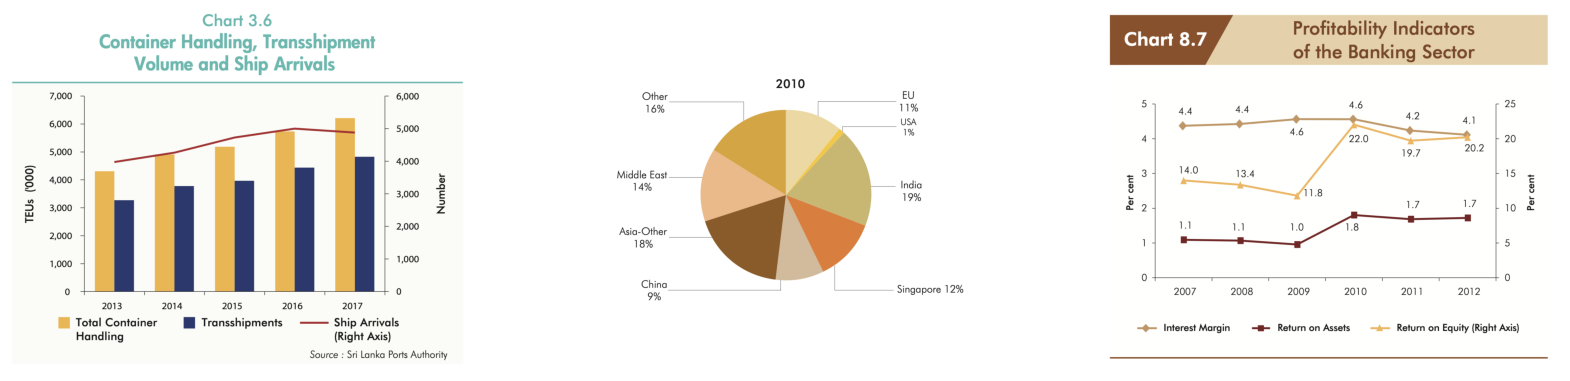

In [2]:
charts = glob('CBSLDataset/charts/*.png')
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
bar_chart = cv2.cvtColor(cv2.imread(charts[609]), cv2.COLOR_BGR2RGB)
pie_chart = cv2.cvtColor(cv2.imread(charts[868]), cv2.COLOR_BGR2RGB)
line_chart = cv2.cvtColor(cv2.imread(charts[45]), cv2.COLOR_BGR2RGB)
ax[0].imshow(bar_chart)
ax[1].imshow(pie_chart)
ax[2].imshow(line_chart)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

##### Read and preprocess images

In [3]:
dim = (128, 128)
chart_types = list(map(lambda x: x.strip('CBSLDataset/charts')[:-9], charts))
img_cv2 = list(map(lambda path: cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), dim), charts))
data_dic = {'file_path': charts, 'img_cv2': img_cv2, 'chart_type': chart_types}
data = pd.DataFrame(data_dic)
img_cv2 = np.stack(img_cv2)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

oht = OneHotEncoder(sparse_output=False)
chart_types_tr = oht.fit_transform(np.array(chart_types).reshape(-1, 1))
X_train, X_val, y_train, y_val = train_test_split(img_cv2, chart_types_tr)
X_train = X_train/255
X_test = X_val/255

In [5]:
oht.categories_

[array(['bar', 'line', 'pie'], dtype='<U4')]

##### Build, compile and train a shallow NN

##### Build, compile and train a CNN

In [8]:
# Define F1 score as a custom metric since Keras does not include F1 score in its list of predefined metrics.
from keras import backend as K
from keras.metrics import Precision, Recall, categorical_accuracy

precision = Precision()
recall = Recall()

@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1 = 2 * precision_value * recall_value / (precision_value + recall_value + K.epsilon())
    return f1

In [9]:
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras import Model
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import EarlyStopping

kernel_size = (3, 3)
pool_size = (2, 2)

input_ = Input(shape=X_train.shape[1:])
conv2d_1 = Conv2D(filters=64, kernel_size=kernel_size, activation='relu')(input_)
pooling_1 = MaxPooling2D(pool_size=pool_size)(conv2d_1)
conv2d_2 = Conv2D(filters=128, kernel_size=kernel_size, activation='relu')(pooling_1)
pooling_2 = MaxPooling2D(pool_size=pool_size)(conv2d_2)
flatten = Flatten()(pooling_2)
dense = Dense(100, activation='relu')(flatten)
output = Dense(3, activation='softmax')(dense)
cnn_model = Model(inputs=[input_], outputs=[output], name='CNN')
cnn_model.summary()

early_stopping = EarlyStopping(monitor='loss', patience=3)
cnn_model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=[f1_score, categorical_accuracy])
history = cnn_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │    11,520,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,596,051 (44.24 MB)

 Trainable params: 11,596,051 (44.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 321ms/step - categorical_accuracy: 0.4494 - f1_score: 0.2549 - loss: 1.1131 - val_categorical_accuracy: 0.4419 - val_f1_score: 0.2291 - val_loss: 1.0154
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 310ms/step - categorical_accuracy: 0.4682 - f1_score: 0.2180 - loss: 1.0102 - val_categorical_accuracy: 0.6367 - val_f1_score: 0.2497 - val_loss: 0.9724
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step - categorical_accuracy: 0.5289 - f1_score: 0.2477 - loss: 0.9713 - val_categorical_accuracy: 0.7079 - val_f1_score: 0.2618 - val_loss: 0.9105
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 328ms/step - categorical_accuracy: 0.5499 - f1_score: 0.2652 - loss: 0.9287 - val_categorical_accuracy: 0.4981 - val_f1_score: 0.3048 - val_loss: 1.1000
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - categorical_accuracy: 0.5593 - f1_score: 0.3202 - loss: 0.8983 - val_categorical_accuracy: 0.7266 - val_f1_score: 0.3584 - val_loss: 0.7202
Epoch 6/20
25/25 ━━━━━━━━━━━━━

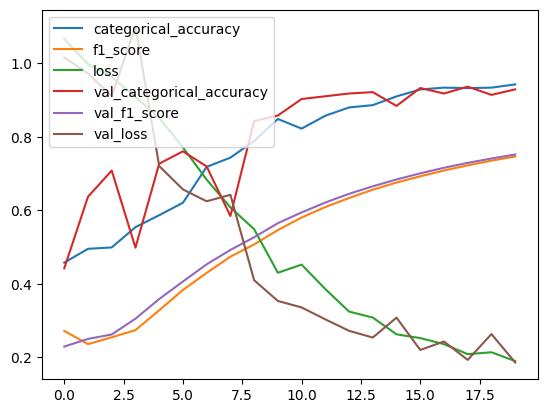

In [10]:
pd.DataFrame(history.history).plot()
plt.show()

In [11]:
cnn_model.evaluate(X_val, y_val)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - categorical_accuracy: 0.9003 - f1_score: 0.7535 - loss: 0.2478


[0.1856566220521927, 0.7540482878684998, 0.9288389682769775]

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


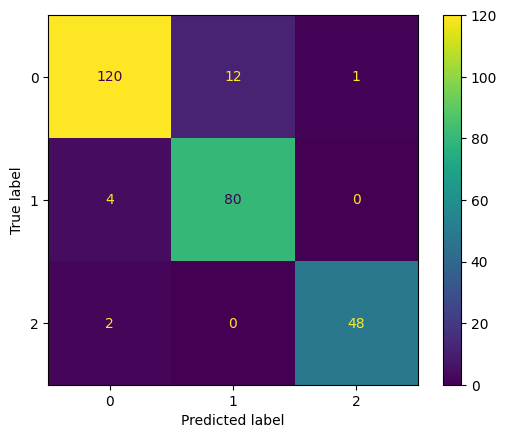

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_probabilities = cnn_model.predict(X_test)
predictions = np.argmax(predicted_probabilities, axis=1)
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), predictions)
conf_mat_display = ConfusionMatrixDisplay(conf_mat)
conf_mat_display.plot()
plt.show()

##### Missed Classifications

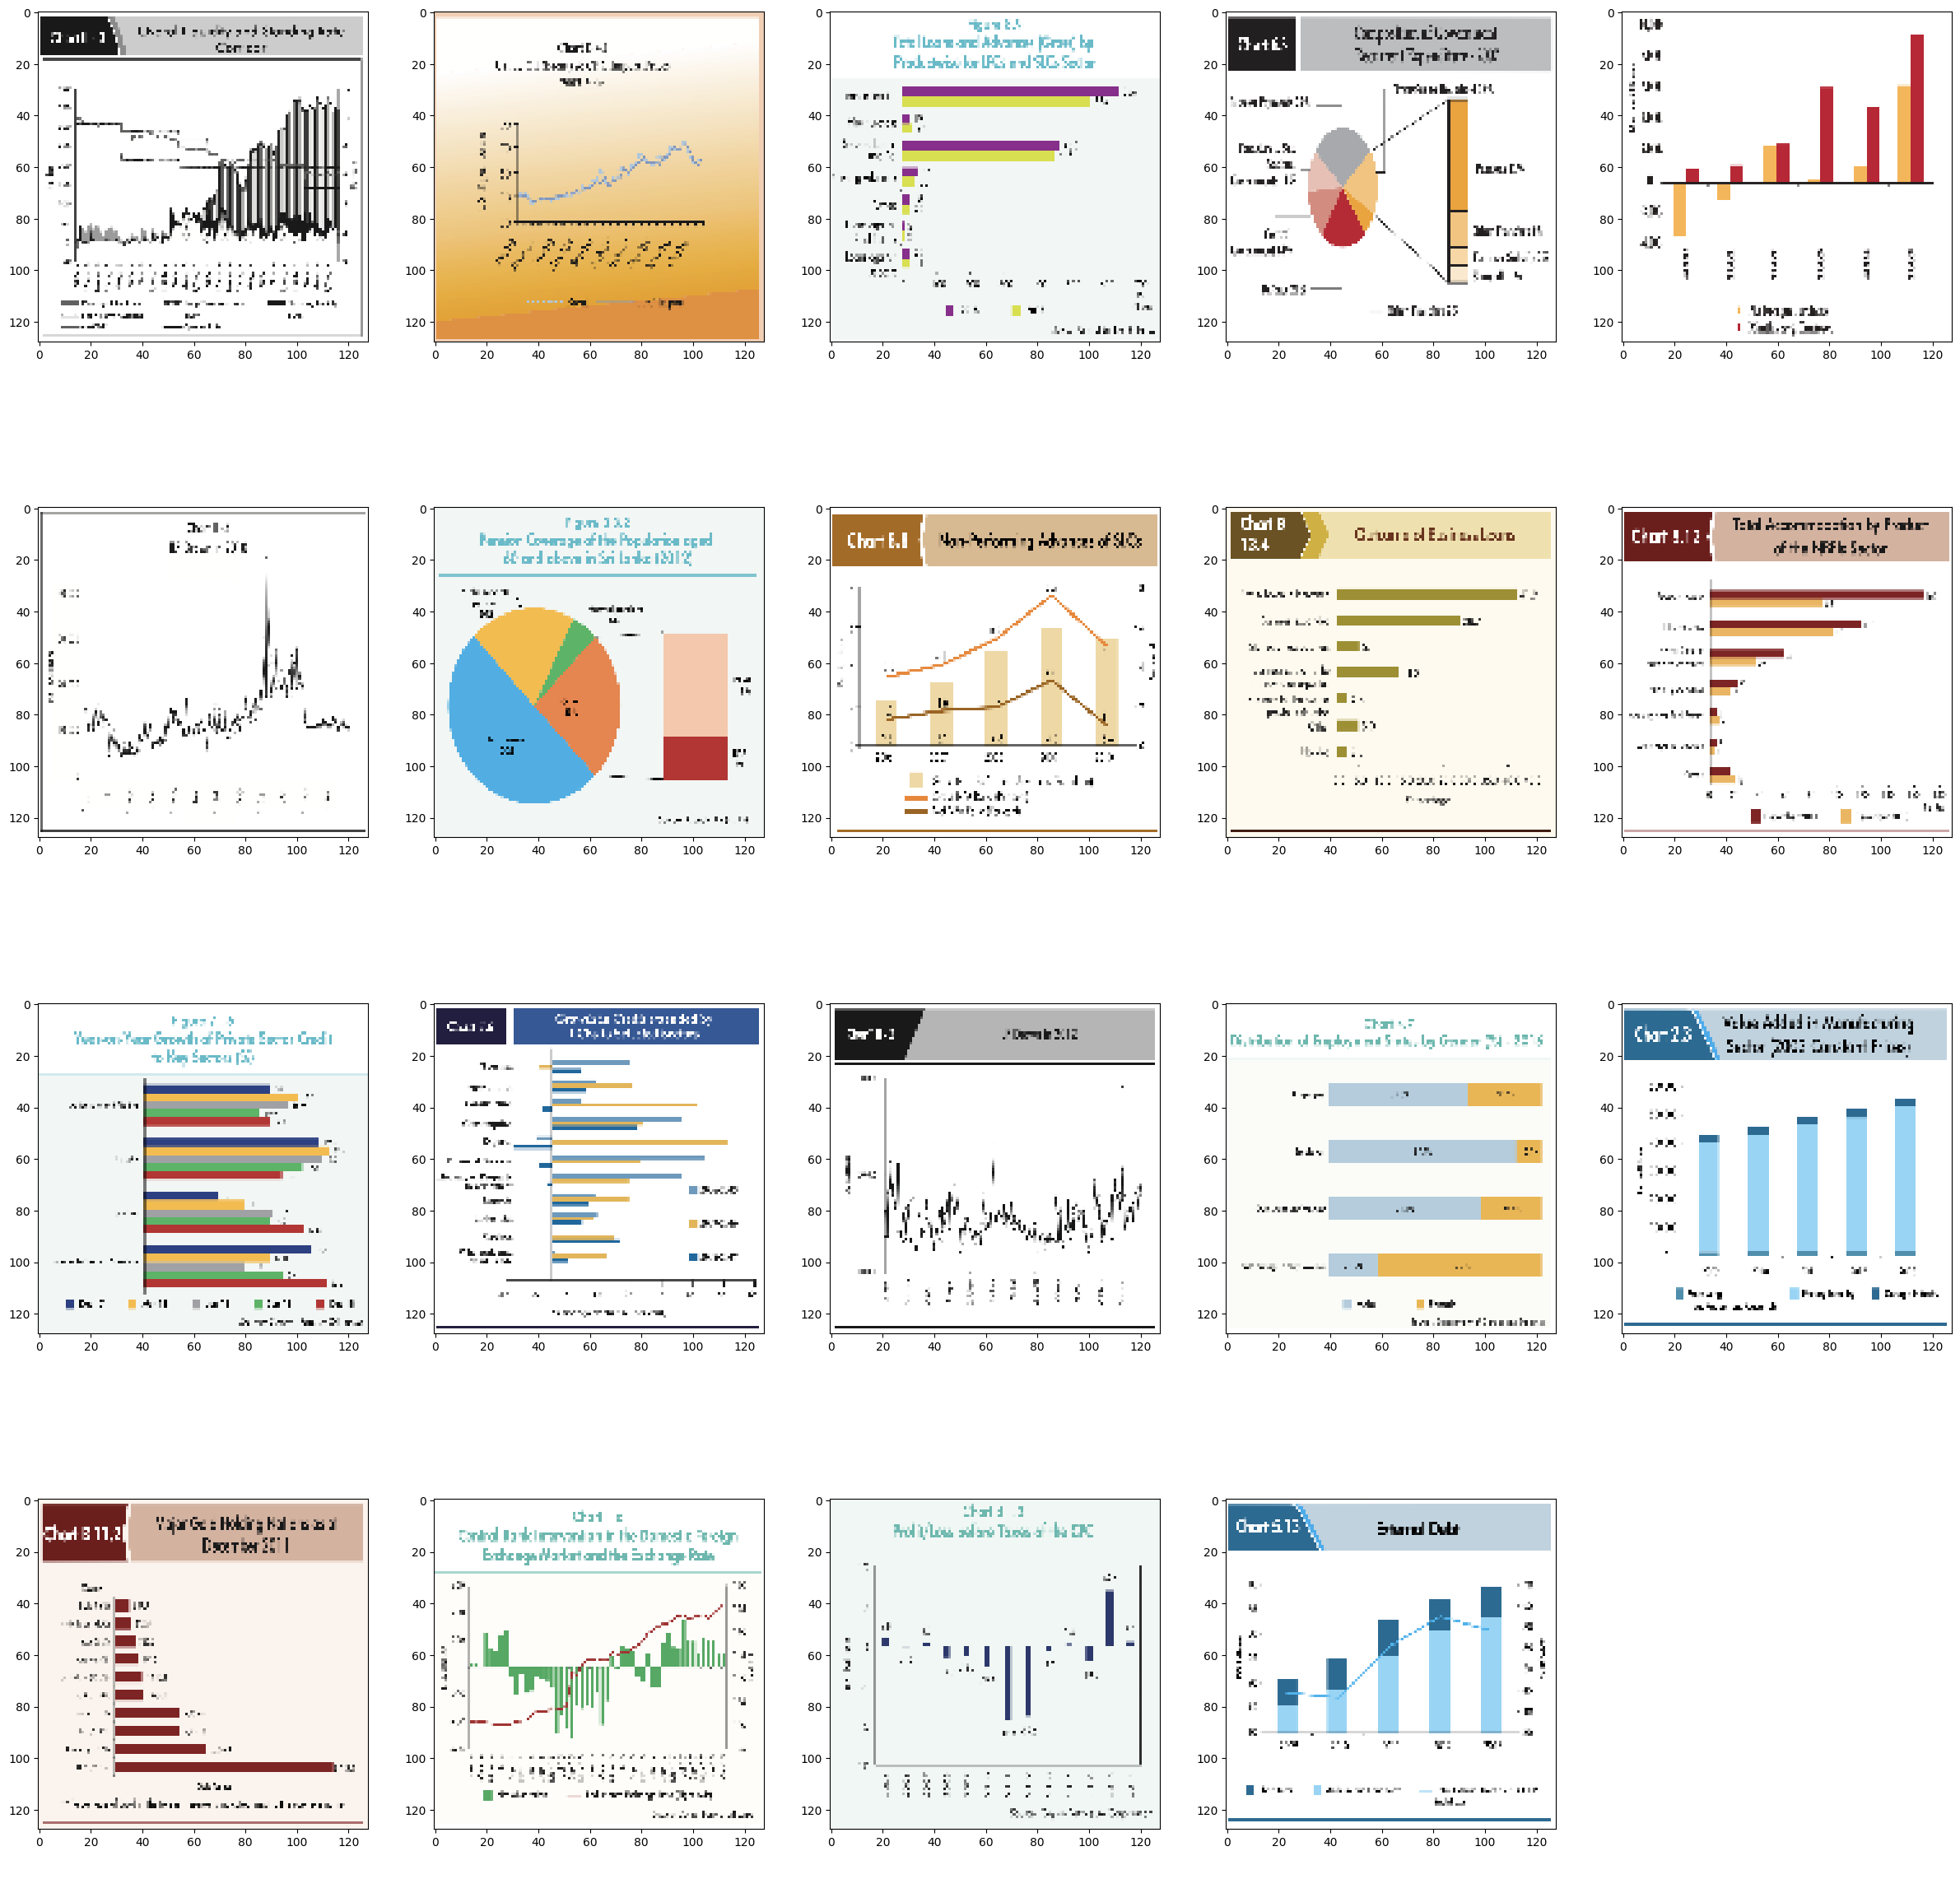

In [13]:
miss_pred = np.where(np.argmax(y_test, axis=1) != predictions)[0]
n_cols = 5
n_rows = np.ceil(len(miss_pred) / n_cols).astype(np.uint8)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 30))
axes = axes.ravel()

for i in range(n_rows * n_cols):
    try:
        axes[i].imshow(X_test[miss_pred[i]])
    except IndexError:
        axes[i].axis('off')

##### Save the model

In [14]:
cnn_model.save('SavedModels/chart-type-classifier-2.keras')

##### Inference

In [15]:
import cv2
import numpy as np
from keras.models import load_model

def model_predict(path, saved_model):
    dim = saved_model.input_shape[1:-1]
    img = cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), dim) / 255
    img_exp = np.expand_dims(img, axis=0)
    prediction = np.argmax(saved_model(img_exp).numpy())
    return prediction

saved_model = load_model('SavedModels/chart-type-classifier-2.keras')
model_predict(path='eval/chart.png', saved_model=saved_model)

1